In [11]:
import numpy as np
import pr3_utils 
from pr3_torch_utils import *
from stereo import *
from tqdm import tqdm

In [12]:
dataset = "03"
features_sample_step = 10

time_stamp,features,linear_velocity,angular_velocity,k,b,imu_T_cam = \
    load_data_torch(f"../data/{dataset}.npz")


num_time_stamp = time_stamp.shape[0]
features = features[:, ::features_sample_step, :]
num_features = features.shape[1]

tau = (time_stamp[1:] - time_stamp[:-1]).to(dtype=DTYPE, device=DEVICE)
velocity = torch.concatenate([linear_velocity, angular_velocity], dim=1)

In [13]:
cam_T_imu = inversePose(imu_T_cam)
fsu = k[0,0]
fsv = k[1,1]
cu  = k[0,2]
cv  = k[1,2]
Ks = torch.tensor([
    [fsu,0,cu,0],
    [0,fsv,cv,0],
    [fsu,0,cu,-fsu*b],
    [0,fsv,cv,0],
],dtype=DTYPE, device=DEVICE)
P = torch.tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,0],
],dtype=DTYPE, device=DEVICE)

In [14]:
def odot(s):
    '''
    s: shape (4,)
    '''
    re = torch.zeros([4,6], dtype=s.dtype, device=s.device)
    re[:3,:3] = torch.eye(3)
    re[:3,3:] = -axangle2skew(s[...,:3])
    return re

In [33]:
# noise model
W = 1e-3
V = 5

# log list
log_M_covar_norm_t = []
log_M_covar_norm = []
log_T_predict_innovation = []
log_T_update_innovation = []

# init
T_mean = torch.zeros([num_time_stamp, 4, 4], 
                     dtype=DTYPE, device=DEVICE)
T_covar = torch.zeros([num_time_stamp, 6, 6], 
                     dtype=DTYPE, device=DEVICE)
M_mean = torch.from_numpy(np.load(f"../data/M_init_{dataset}.npy")[::features_sample_step, :])\
        .to(dtype=DTYPE, device=DEVICE)
covar_flat = 1e-3*torch.eye(num_features*3+6, num_features*3+6, 
                       dtype=DTYPE, device=DEVICE)
covar_flat[-6:,-6:] = 0.001*torch.eye(6)
covar = covar_flat.view(num_features+2, 3, num_features+2, 3)
T_mean[0,:,:] = torch.tensor([
    [1, 0, 0,0],
    [0, 1, 0,0],
    [0, 0, 1,0],
    [0, 0, 0,1],
])


# EKF
for t in tqdm(range(1, num_time_stamp)):
    # predict step
    T_mean[t,:,:] = T_mean[t-1,:,:] @ twist2pose(tau[t-1]*axangle2twist(velocity[t]))
    F = twist2pose(-tau[t-1]*axangle2adtwist(velocity[t]))
    log_T_predict_innovation.append(torch.linalg.norm(velocity[t]).item())
    covar_flat[-6:,:-6] = F @ covar_flat[-6:,:-6]
    covar_flat[:-6,-6:] = covar_flat[-6:,:-6].T
    covar_flat[-6:,-6:] = F @ covar_flat[-6:,-6:] @ F.T + W*torch.eye(6,dtype=DTYPE,device=DEVICE)
    T_covar[t,:,:] = covar_flat[-6:,-6:]
    
    # update step
    present_mask = get_seeing_mask_torch(features[t,:,:], d_min=5)
    Nt = int(torch.sum(present_mask))
    if Nt == 0:
        continue
    # compose observation
    present_M_mean = M_mean[present_mask, :]
    present_M_mean_homo = torch.hstack([present_M_mean, torch.ones([Nt,1],device=present_M_mean.device)])
    # build H
    H = torch.zeros([Nt, 4, num_features+2, 3], dtype=DTYPE, device=DEVICE)
    imu_T_world = inversePose(T_mean[t,:,:])
    cam_T_world = cam_T_imu @ imu_T_world
    i_list = torch.where(present_mask == True)[0].detach().cpu().tolist()
    for j, i in enumerate(i_list):
        # δh(T, m_j) / δm_j
        H[j,:,i,:] = Ks @ \
            projectionJacobian(cam_T_world @ present_M_mean_homo[j,:]) @ \
            cam_T_world @ P.T
        # δh(T, m_j) / δT
        ''' ToDo: issue here, causing singularity'''
        H2 = -Ks @ \
            projectionJacobian(cam_T_world @ present_M_mean_homo[j,:]) @ \
            cam_T_imu @ odot(present_M_mean_homo[j,:] @ imu_T_world.T)
        H[j,:,-2:,:] = (H2).reshape(1,4,2,3)
    H = H.reshape([Nt*4, (num_features+2)*3])
    # Kalman gain and innovation 
    K = covar_flat @ H.T @ torch.linalg.inv(H @ covar_flat @ H.T + V*torch.eye(Nt*4,dtype=DTYPE,device=DEVICE))
    innovation = K @ (
        features[t,present_mask,:] - (projection(present_M_mean_homo @ cam_T_world.T)@Ks.T)
    ).reshape(-1)
    if torch.isnan(innovation).any():
        print("nan at", t)
        break
    innovation_M = innovation[:num_features*3]
    innovation_T = innovation[num_features*3:]
    # update
    M_mean = M_mean + innovation_M.reshape(-1, 3)
    T_mean[t,:,:] = T_mean[t,:,:] @ axangle2pose(innovation_T)
    log_T_update_innovation.append(torch.linalg.norm(innovation_T).item())
    covar_flat = (torch.eye((num_features+2)*3, dtype=DTYPE, device=DEVICE) - K@H) @ covar_flat
    
    # log covariance
    # if t%50 == 0:
    #     log_M_covar_norm_t.append(time_stamp[t].item())
    #     log_M_covar_norm.append(torch.linalg.norm(covar).item())
    # break

100%|██████████| 1009/1009 [00:23<00:00, 43.74it/s]


[]

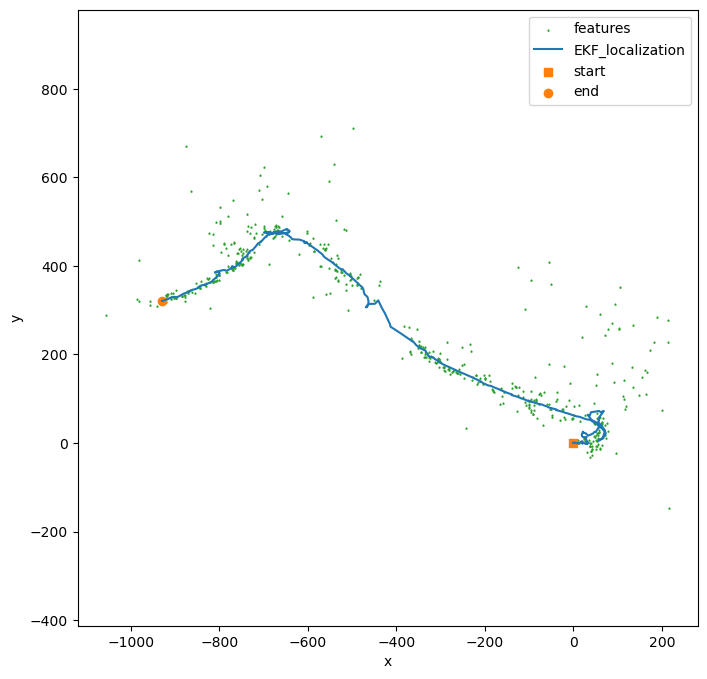

In [34]:
fig,_ = pr3_utils.visualize_trajectory(
    T_mean.detach().cpu().numpy(), 
    features=M_mean.detach().cpu().numpy(),
    show_ori=False, path_name="EKF_localization")
# fig.savefig(f"../img/EKF_SLAM_{dataset}", dpi=300)
pr3_utils.plt.plot()

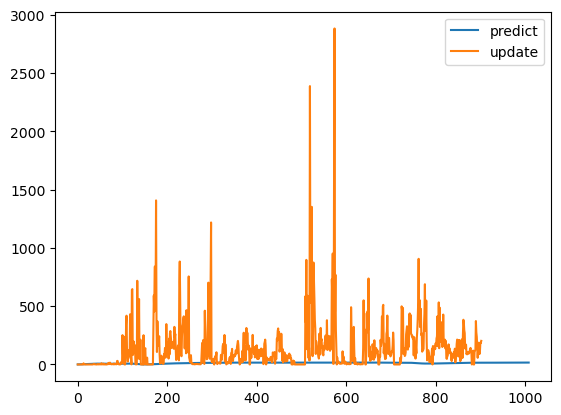

In [25]:
pr3_utils.plt.plot(range(len(log_T_predict_innovation)), log_T_predict_innovation, label="predict")
pr3_utils.plt.plot(range(len(log_T_update_innovation)), log_T_update_innovation, label="update")
pr3_utils.plt.legend()
pr3_utils.plt.show()

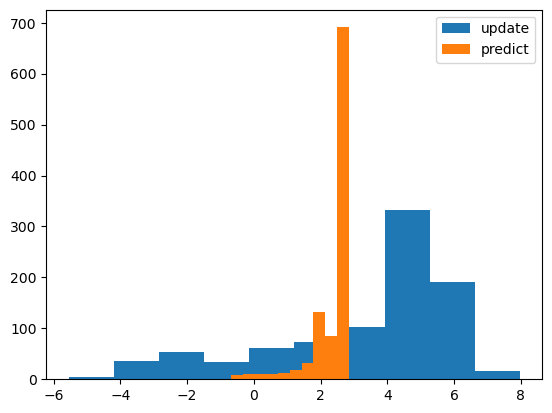

In [26]:
pr3_utils.plt.hist(np.log(log_T_update_innovation), label='update')
pr3_utils.plt.hist(np.log(log_T_predict_innovation), label="predict")
pr3_utils.plt.legend()
pr3_utils.plt.show()

In [18]:
np.exp(2.5)

12.182493960703473

[]

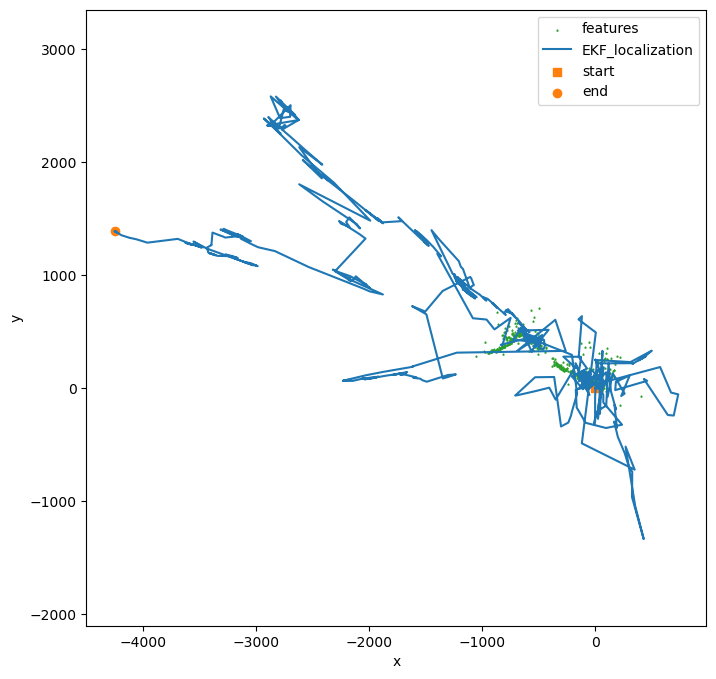